In [1]:
import numpy as np
import scanpy as sc
import anndata
import scvi
from scib_metrics.benchmark import Benchmarker
%matplotlib inline
import torch
from functions import *

/local/data/scvi-tools/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/local/data/scvi-tools/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',
/local/data/anaconda3/envs/BT/lib/python3.11/site-pac

In [33]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [36]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [37]:
sc.pp.highly_variable_genes(adata, n_top_genes=15148, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

In [38]:
adata = adata[:, adata.var.highly_variable].copy()

In [39]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [40]:
%%capture
import scanorama

# List of adata per batch
batch_cats = adata.obs.batch.cat.categories
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["Scanorama"][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]

In [41]:
import pyliger

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDepreca

KeyboardInterrupt: 

In [ ]:
adata.write_h5ad(filename="data/adataw.h5ad")

In [2]:
adata = anndata.read_h5ad(filename="data/adataw.h5ad")
adata

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca'
    obsm: 'LIGER', 'Scanorama', 'Unintegrated', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [20]:
sdnormalAdata, vaeSD = trainModelBenchmark(anndata.read_h5ad(filename="data/adataw.h5ad"), "sdnormal",max_epochs=100)

/local/data/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/100:   1%|          | 1/100 [00:01<02:48,  1.70s/it, v_num=1, train_loss_step=614, train_loss_epoch=662]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/100:   5%|▌         | 5/100 [00:08<02:50,  1.79s/it, v_num=1, train_loss_step=553, train_loss_epoch=562]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 49/100:  48%|████▊     | 48/100 [01:22<01:28,  1.69s/it, v_num=1, train_loss_step=560, train_loss_epoch=514]

/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
normalAdata, vaeN = trainModelBenchmark(anndata.read_h5ad(filename="data/adataw.h5ad"), "normal",max_epochs=200)

/local/data/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/200:   0%|          | 1/200 [00:01<05:43,  1.72s/it, v_num=1, train_loss_step=571, train_loss_epoch=660]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 200/200: 100%|██████████| 200/200 [05:26<00:00,  1.64s/it, v_num=1, train_loss_step=529, train_loss_epoch=517]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [05:26<00:00,  1.63s/it, v_num=1, train_loss_step=529, train_loss_epoch=517]


In [3]:
mogAdata, vaeMG = trainModelBenchmark(anndata.read_h5ad(filename="data/adataw.h5ad"), "mixofgaus",max_epochs=300)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/local/data/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/300:   0%|          | 0/300 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/300:   0%|          | 1/300 [00:02<10:47,  2.17s/it, v_num=1, train_loss_step=636, train_loss_epoch=659]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/300:   2%|▏         | 5/300 [00:10<10:01,  2.04s/it, v_num=1, train_loss_step=503, train_loss_epoch=560]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 300/300: 100%|██████████| 300/300 [09:44<00:00,  1.98s/it, v_num=1, train_loss_step=551, train_loss_epoch=517]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [09:44<00:00,  1.95s/it, v_num=1, train_loss_step=551, train_loss_epoch=517]


In [ ]:
vampAdata, vaeVP = trainModelBenchmark(anndata.read_h5ad(filename="data/adataw.h5ad"), "vamp",max_epochs=100)

/local/data/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/100:   1%|          | 1/100 [00:02<03:45,  2.28s/it, v_num=1, train_loss_step=556, train_loss_epoch=660]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 100/100: 100%|██████████| 100/100 [03:35<00:00,  2.16s/it, v_num=1, train_loss_step=483, train_loss_epoch=513]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [03:35<00:00,  2.15s/it, v_num=1, train_loss_step=483, train_loss_epoch=513]


In [3]:
vampAdata6, vaeVP6 = trainModelBenchmark(anndata.read_h5ad(filename="data/adataw.h5ad"), "vamp",max_epochs=600, save="models/vamp600")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/local/data/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/600:   0%|          | 1/600 [00:02<24:27,  2.45s/it, v_num=1, train_loss_step=555, train_loss_epoch=660]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/600:   1%|          | 5/600 [00:12<24:24,  2.46s/it, v_num=1, train_loss_step=563, train_loss_epoch=559]

/local/data/scvi-tools/scvi/module/_vae.py:519: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 600/600: 100%|██████████| 600/600 [21:49<00:00,  2.22s/it, v_num=1, train_loss_step=526, train_loss_epoch=517]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [21:49<00:00,  2.18s/it, v_num=1, train_loss_step=526, train_loss_epoch=517]


Computing neighbors:   0%|          | 0/4 [00:00<?, ?it/s]/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/local/data/anaconda3/

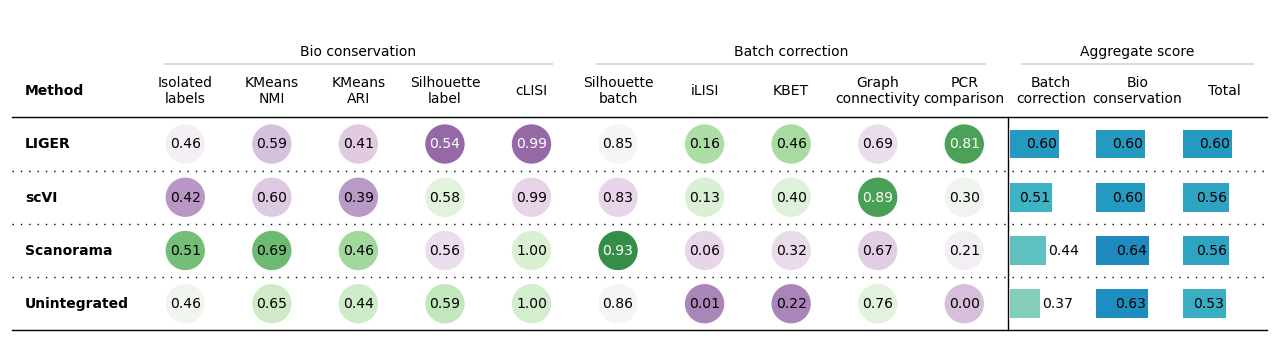

In [4]:
plotBenchmarkResults(vampAdata6)

Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 4/4 [03:59<00:00, 59.96s/it]


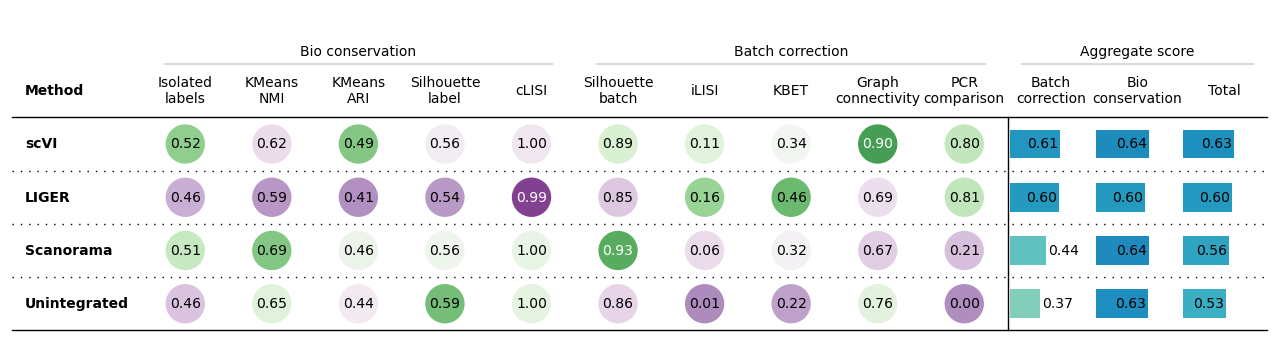

In [11]:
plotBenchmarkResults(mogAdata)

Computing neighbors:   0%|          | 0/4 [00:00<?, ?it/s]/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/local/data/anaconda3/

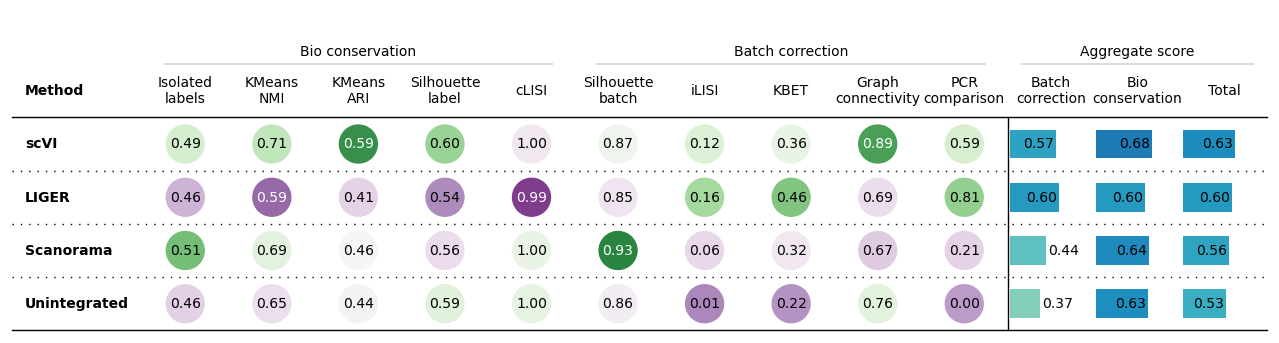

In [4]:
plotBenchmarkResults(mogAdata)

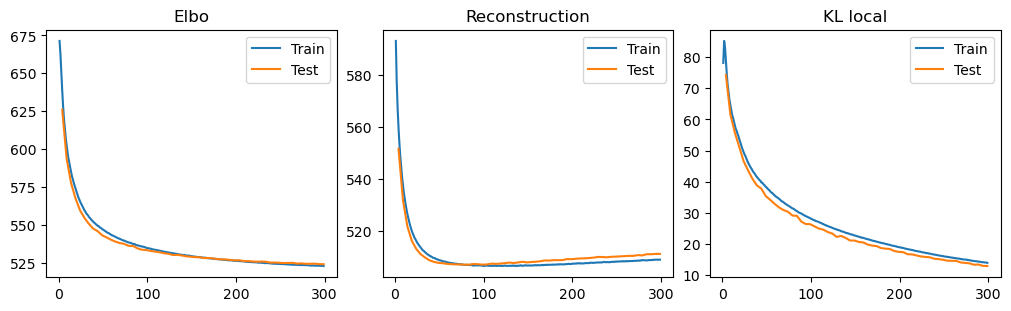

In [10]:
plotAllHistory(vaeMG)

In [6]:
vaeMG.module.prior.mean

Parameter containing:
tensor([[-1.1296, -0.2582,  0.4108,  ..., -0.3712,  0.1689, -0.3579],
        [ 2.2610, -0.5529, -0.4089,  ..., -0.5303,  1.2506, -0.2677],
        [-1.7499, -0.3452, -0.4309,  ...,  0.7842, -0.7287, -1.7064],
        ...,
        [ 0.8815,  1.4591,  0.1858,  ..., -0.5171, -1.2176, -0.0383],
        [ 2.4342,  1.1446,  1.1641,  ..., -0.7755, -0.2485, -1.1160],
        [-0.4493, -0.2226,  1.8575,  ...,  0.9769,  1.7604, -0.8616]],
       device='cuda:0', requires_grad=True)

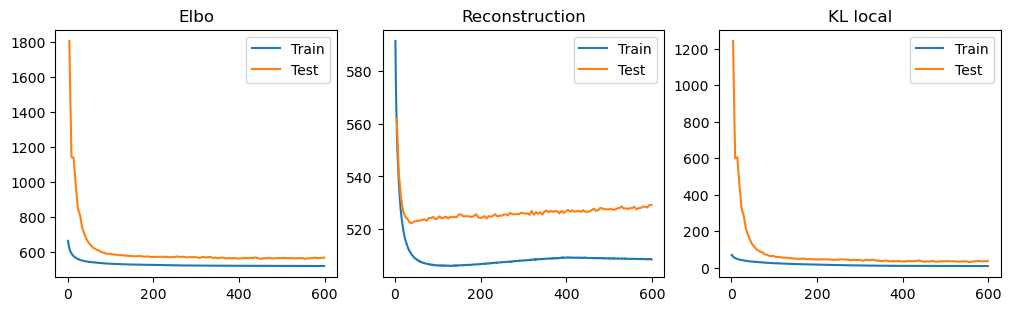

In [6]:
plotAllHistory(vaeVP6)

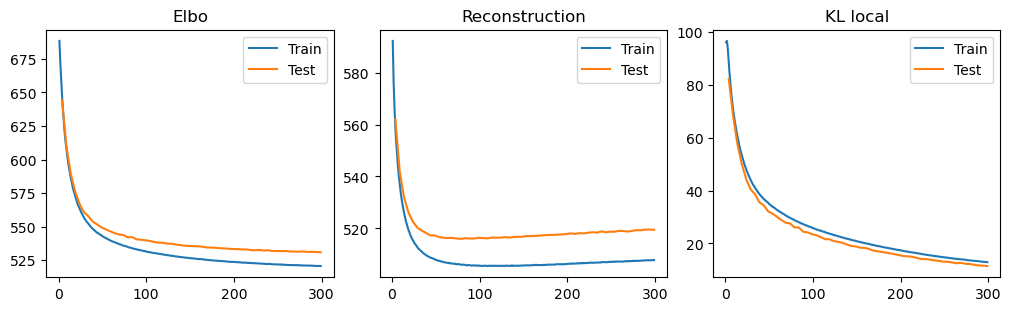

In [5]:
plotAllHistory(vaeMG)